In [25]:
import json
import os
import numpy as np


def calculate_scores(data1, data2):
    """
    Calcule les scores pour chaque stock en fonction de son GICS Sector.
    """
    # Dictionnaire pour stocker les scores pour chaque date et chaque stock
    result = {}

    # Pour chaque date dans le premier fichier JSON
    for date, stocks in data1.items():
        result[date] = {}

        # Regrouper les stocks par secteur GICS
        gics_sector_dict = {}
        gics_subsector_dict = {}
        for stock, values in stocks.items():
            gics_sector = data2[stock]["GICS Sector"]
            gics_subsector = data2[stock]["GICS Sub-Industry"]
            if gics_sector not in gics_sector_dict:
                gics_sector_dict[gics_sector] = []
            if gics_subsector not in gics_subsector_dict:
                gics_subsector_dict[gics_subsector] = []
            gics_sector_dict[gics_sector].append(values)
            gics_subsector_dict[gics_subsector].append(values)

        # Calculer les scores pour chaque stock
        for stock, values in stocks.items():
            gics_sector = data2[stock]["GICS Sector"]
            gics_subsector = data2[stock]["GICS Sub-Industry"]
            
            # Extraire les valeurs à normaliser
            roe = values["ROE"]
            debt_to_equity = values["DebtToEquity"]
            profit_margin = values["ProfitMargin"]
            operating_cash_flow_debt = values["OperatingCashFlowDebt"]
            market_cap = values["MarketCap"]
            dividend_yield = values["DividendYield"]
            market_to_book = values["MarketToBook"]
            adj_close = values["Adj Close"]

            # Calculer mean et std pour chaque métrique dans le secteur GICS
            gics_stocks = gics_sector_dict[gics_sector]
            gics_sub_stocks = gics_subsector_dict[gics_subsector]
            roe_values = [s["ROE"] for s in gics_stocks]
            debt_to_equity_values = [s["DebtToEquity"] for s in gics_stocks]
            operating_cash_flow_debt_values = [s["OperatingCashFlowDebt"] for s in gics_stocks]
            market_cap_values = [s["MarketCap"] for s in gics_stocks]
            dividend_yield_values = [s["DividendYield"] for s in gics_stocks]
            market_to_book_values = [s["MarketToBook"] for s in gics_stocks]
            profit_margin_values = [s["ProfitMargin"] for s in gics_stocks]
            Subdividend_yield_values = [s["DividendYield"] for s in gics_sub_stocks]
            Submarket_to_book_values = [s["MarketToBook"] for s in gics_sub_stocks]
            Submarket_cap_values = [s["MarketCap"] for s in gics_sub_stocks]
            

            roe_mean, roe_std = np.mean(roe_values), np.std(roe_values)
            debt_to_equity_mean, debt_to_equity_std = np.mean(debt_to_equity_values), np.std(debt_to_equity_values)
            operating_cash_flow_debt_mean, operating_cash_flow_debt_std = np.mean(operating_cash_flow_debt_values), np.std(operating_cash_flow_debt_values)
            market_cap_mean, market_cap_std = np.mean(market_cap_values), np.std(market_cap_values)
            dividend_yield_mean, dividend_yield_std = np.mean(dividend_yield_values), np.std(dividend_yield_values)
            market_to_book_mean, market_to_book_std = np.mean(market_to_book_values), np.std(market_to_book_values)
            profit_margin_mean, profit_margin_std = np.mean(profit_margin_values), np.std(profit_margin_values)
            

            # Calculer les scores
            roe_score = (roe - roe_mean) / roe_std if roe_std != 0 else 0
            debt_to_equity_score = -1*(debt_to_equity - debt_to_equity_mean) / debt_to_equity_std if debt_to_equity_std != 0 else 0
            operating_cash_flow_debt_score = (operating_cash_flow_debt - operating_cash_flow_debt_mean) / operating_cash_flow_debt_std if operating_cash_flow_debt_std != 0 else 0
            # market_cap_score = (market_cap - market_cap_mean) / market_cap_std if market_cap_std != 0 else 0
            # dividend_yield_score = (dividend_yield - dividend_yield_mean) / dividend_yield_std if dividend_yield_std != 0 else 0
            # market_to_book_score = (market_to_book - market_to_book_mean) / market_to_book_std if market_to_book_std != 0 else 0
            dividend_yield_score = dividend_yield 
            market_to_book_score = (market_to_book - np.mean(Submarket_to_book_values)) / np.std(Submarket_to_book_values) if np.std(Submarket_to_book_values) != 0 else 0
            profit_margin_score = (profit_margin - profit_margin_mean) / profit_margin_std if profit_margin_std != 0 else 0
            # roe_score = roe / roe_mean if roe_mean != 0 else 0
            # debt_to_equity_score = -1 * (debt_to_equity / debt_to_equity_mean) if debt_to_equity_mean != 0 else 0
            # operating_cash_flow_debt_score = operating_cash_flow_debt / operating_cash_flow_debt_mean if operating_cash_flow_debt_mean != 0 else 0
            market_cap_score = (market_cap - np.mean(Submarket_cap_values))/np.std(Submarket_cap_values) if np.std(Submarket_cap_values) != 0 else 0
            # dividend_yield_score = dividend_yield / dividend_yield_mean if dividend_yield_mean != 0 else 0
            # market_to_book_score = market_to_book / market_to_book_mean if market_to_book_mean != 0 else 0
            # profit_margin_score = profit_margin / profit_margin_mean if profit_margin_mean != 0 else 0
            quality_score = np.mean([roe_score, debt_to_equity_score, profit_margin_score, operating_cash_flow_debt_score])

            # Ajouter les scores au résultat
            result[date][stock] = {
                "ROE_score": roe_score,
                "DebtToEquity_score": debt_to_equity_score,
                "OperatingCashFlowDebt_score": operating_cash_flow_debt_score,
                "ProfitMargin_score": profit_margin_score,
                "Quality_score": quality_score,
                "MarketCap_score": market_cap_score,
                "DividendYield_score": dividend_yield_score,
                "MarketToBook_score": market_to_book_score,
                "Adj Close": adj_close  # La valeur d'Adj Close reste inchangée
            }

    return result

def generate_score_file(json_file_1, json_file_2, output_dir):
    """
    Prend deux fichiers JSON et génère un fichier JSON de scores dans le dossier de sortie.
    """
    # Charger les fichiers JSON
    with open(json_file_1, 'r') as f1:
        data1 = json.load(f1)
    
    with open(json_file_2, 'r') as f2:
        data2 = json.load(f2)

    # Calculer les scores
    scores = calculate_scores(data1, data2)

    # Générer le chemin de sortie
    os.makedirs(output_dir, exist_ok=True)
    output_file = os.path.join(output_dir, "SP500DailyComponentsMetrics.json")

    # Sauvegarder le fichier JSON des scores
    with open(output_file, 'w') as outfile:
        json.dump(scores, outfile, indent=4)

    print(f"Fichier de scores généré : {output_file}")

In [26]:
generate_score_file('SP500ComponentsDailyFinanRatios.json', 'filtered_sp500_components.json', 'output')

Fichier de scores généré : output\SP500DailyComponentsMetrics.json


In [27]:
import json
import math
import os

def generate_etf(json_path, output_folder, term):
    # Validation des termes
    score_mapping = {
        "Quality": "Quality_score",
        "Value": "MarketToBook_score",
        "Dividend": "DividendYield_score",
        "MarketCap": "MarketCap_score"
    }

    if term not in score_mapping:
        raise ValueError("Term invalide. Veuillez choisir parmi: 'Quality', 'Value', 'Dividend', 'MarketCap'.")

    score_key = score_mapping[term]

    # Charger le fichier JSON
    with open(json_path, 'r') as file:
        data = json.load(file)

    etf_weights = {}
    etf_prices = {}

    # Calcul des poids et des prix de l'ETF
    for date, stocks in data.items():
        if score_key=="DividendYield_score":
            # Calculer le maximum des scores pour la stabilité numérique
            max_score = max(stock.get(score_key, 0) for stock in stocks.values())

            # Appliquer log-sum-exp
            total_score = sum(
                math.exp(stock.get(score_key, 0) - max_score) for stock in stocks.values()
            )

        elif score_key=="MarketToBook_score":
            total_score = sum((1/math.exp(stock.get(score_key, 0))) for stock in stocks.values())
        else:
            total_score = sum(math.exp(stock.get(score_key, 0)) for stock in stocks.values())

        if total_score == 0:
            raise ValueError(f"La somme des scores pour la date {date} est nulle, ce qui empêche le calcul des poids.")

        daily_weights = {}
        etf_price = 0

        for stock, metrics in stocks.items():
            if score_key=="DividendYield_score":
                score = math.exp(metrics.get(score_key, 0) - max_score)/8
            elif score_key=="MarketToBook_score":
                score = (1/math.exp(metrics.get(score_key, 0)))
            else:
                score = math.exp(metrics.get(score_key, 0))
            weight = score / total_score
            daily_weights[stock] = weight
            etf_price += weight * metrics.get("Adj Close", 0)

        etf_weights[date] = daily_weights
        etf_prices[date] = etf_price

    # Sauvegarder les fichiers JSON
    os.makedirs(output_folder, exist_ok=True)

    weights_file = os.path.join(output_folder, f"SP500{term}ETFWeights.json")
    prices_file = os.path.join(output_folder, f"SP500{term}ETFPrices.json")

    with open(weights_file, 'w') as file:
        json.dump(etf_weights, file, indent=4)

    with open(prices_file, 'w') as file:
        json.dump(etf_prices, file, indent=4)

    print(f"Fichiers générés :\n{weights_file}\n{prices_file}")

# Exemple d'appel de la fonction
# generate_etf("./output/SP500DailyComponentsMetrics.json", "./output/Quality", "Quality")
# generate_etf("./output/SP500DailyComponentsMetrics.json", "./output/Value", "Value")
generate_etf("./output/SP500DailyComponentsMetrics.json", "./output/Dividend", "Dividend")
generate_etf("./output/SP500DailyComponentsMetrics.json", "./output/MarketCap", "MarketCap")


Fichiers générés :
./output/Dividend\SP500DividendETFWeights.json
./output/Dividend\SP500DividendETFPrices.json
Fichiers générés :
./output/MarketCap\SP500MarketCapETFWeights.json
./output/MarketCap\SP500MarketCapETFPrices.json


In [5]:
from datetime import datetime

from matplotlib import pyplot as plt


def plot_index_values(index_values, index_name, color='blue'):
    """
    Affiche un graphique des valeurs de l'indice.

    Arguments :
        index_values (dict) : Dictionnaire contenant les dates comme clés et les valeurs de l'indice comme valeurs.
    """
    # Convertir les dates (format 'YYYY-MM-DD') en objets datetime
    dates = [datetime.strptime(date, "%Y-%m-%d") for date in index_values.keys()]
    values = list(index_values.values())

    # Créer le graphique
    plt.figure(figsize=(10, 6))
    plt.plot(dates, values, label="Index Value", color=color, marker='.')

    # Ajouter des titres et des labels
    plt.title(f"Evolution des valeurs de l'indice {index_name}")
    plt.xlabel("Date")
    plt.ylabel(f"Valeurs de {index_name}")
    plt.xticks(rotation=45)  # Rotation des dates pour éviter l'empilement
    plt.grid(True)
    plt.tight_layout()

    # Afficher le graphique
    plt.legend()
    plt.show()

In [6]:
def plotter(term, color):
    filePath = f"./output/{term}/SP500{term}ETFPrices.json"
    with open(filePath, 'r') as file:
        data = json.load(file)
    plot_index_values(data, f"SP500{term}ETF", color)

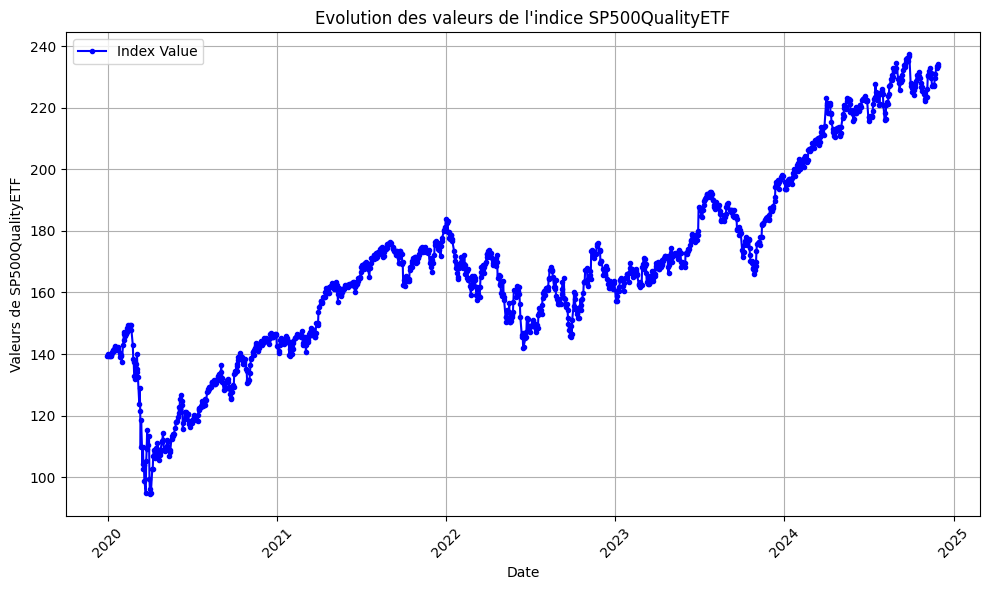

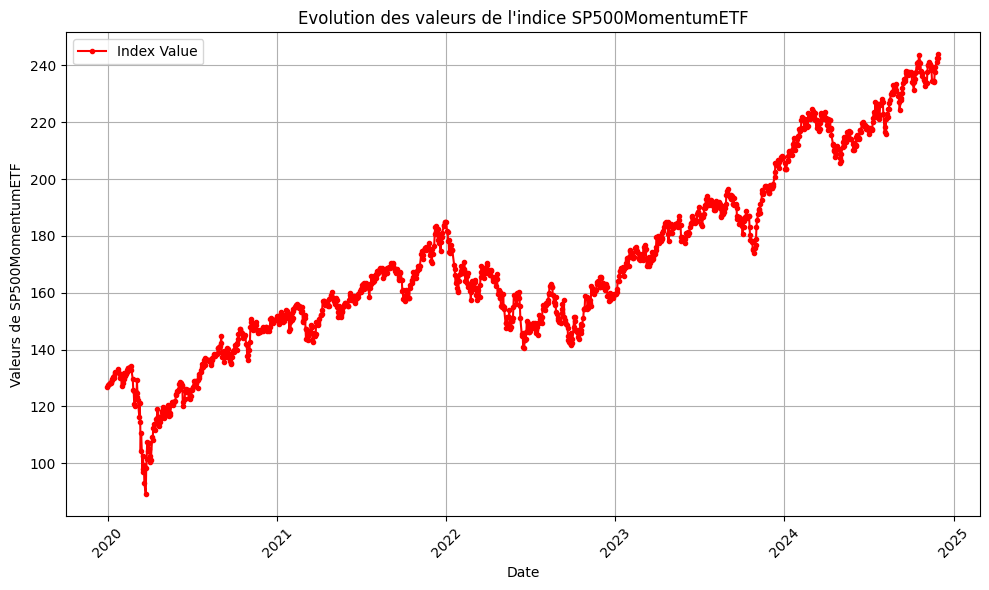

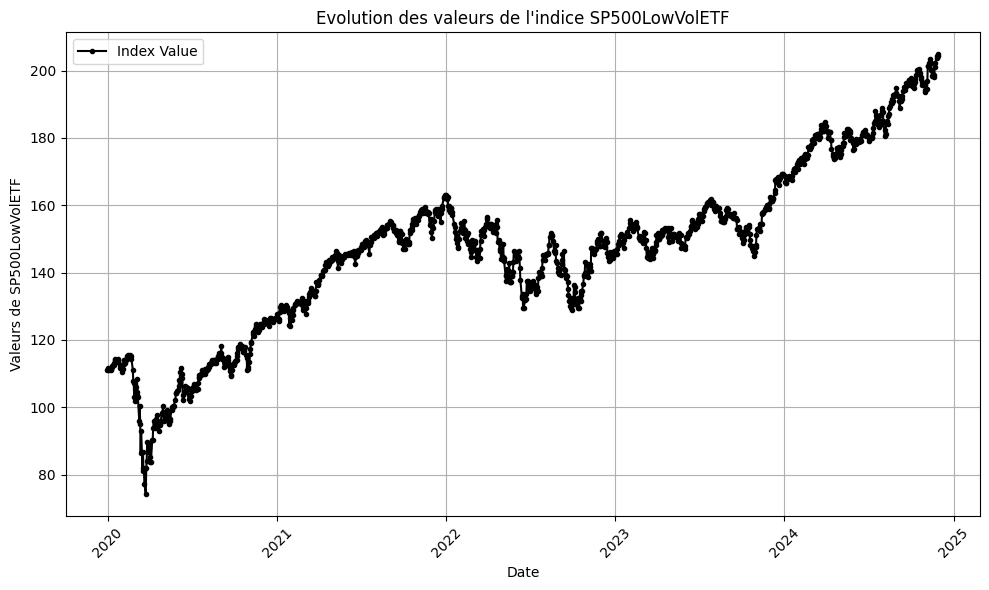

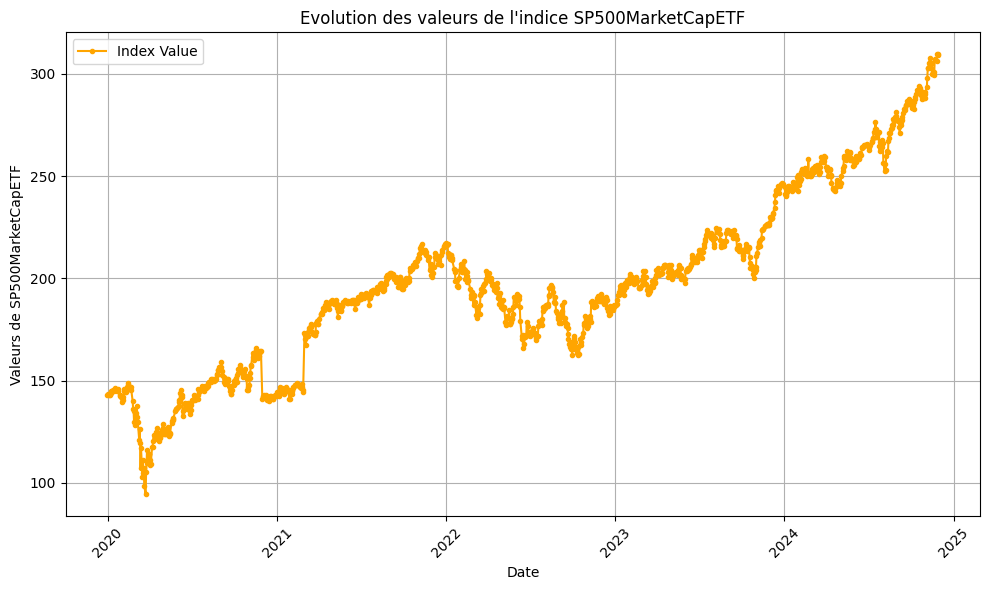

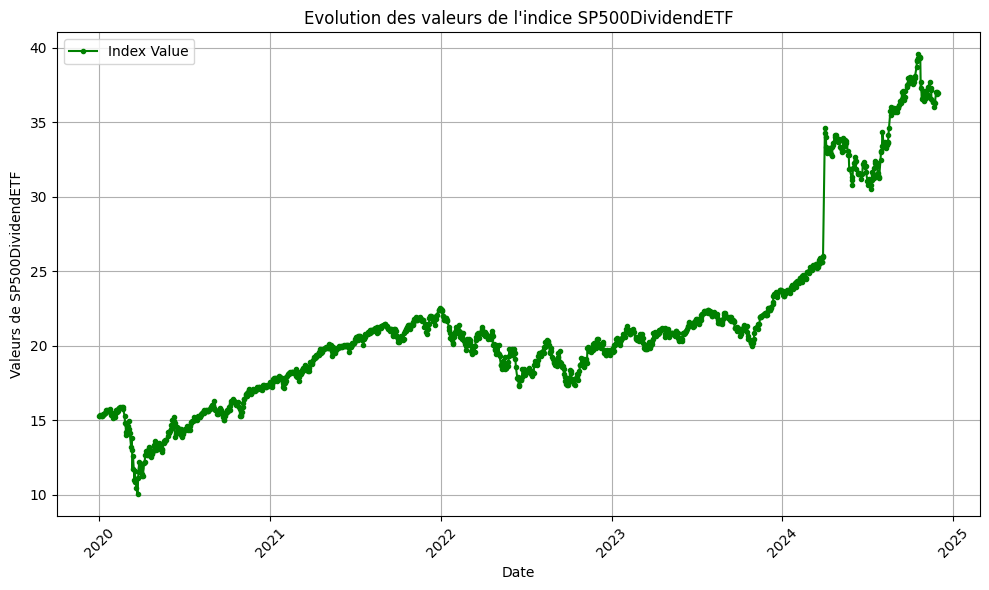

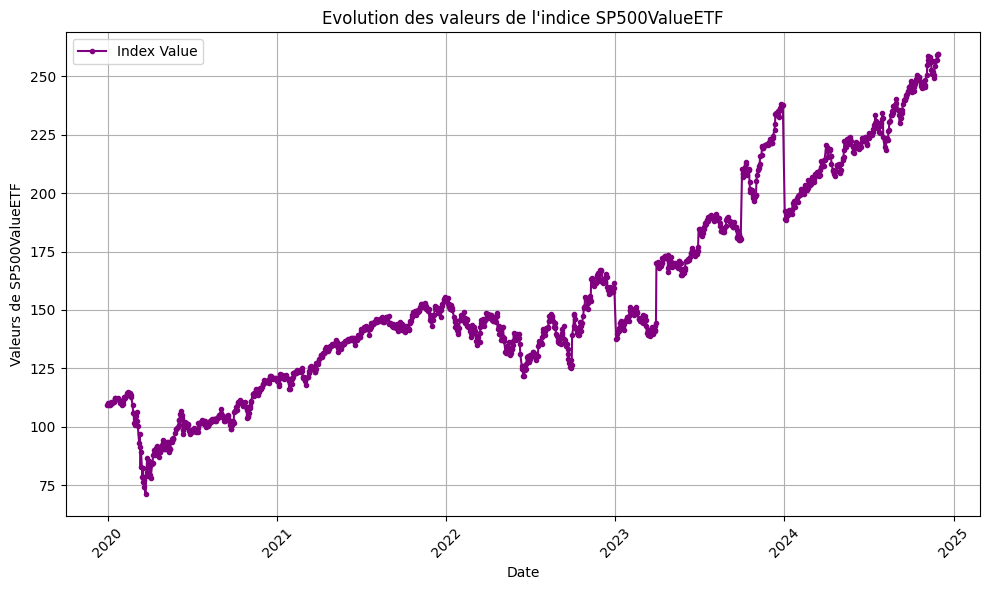

In [28]:

plotter("Quality", 'blue')
plotter("Momentum", 'red')
plotter("LowVol", 'black')
plotter("MarketCap", 'orange')
plotter("Dividend", 'Green')
plotter("Value", 'purple')
